# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import scipy.stats as stats
import pylab

# matplotlib setup
%matplotlib inline

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
#This function will be used quite often 

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x: sort the data
    x = np.sort(data)

    # y: range for y-axis
    y = np.arange(1, n+1) / n

    return x, y

def bootstrap(df, size):
    np.random.seed(42)
    size = 10000
    bs_replicates_m = np.empty(size)

    for i in range(size):
        bs_sample_m = np.random.choice(df, len(df))
        bs_replicates_m[i] = np.mean(bs_sample_m)
    return bs_replicates_m

<div class="span5 alert alert-info">
<p><h3>Running some basic statistics on the dataset</h3></p>
</div> 


In [4]:
data[['call']].groupby(data.race).describe()

call                                             
       count      mean       std  min  25%  50%  75%  max
race                                                     
b     2435.0  0.064476  0.245649  0.0  0.0  0.0  0.0  1.0
w     2435.0  0.096509  0.295346  0.0  0.0  0.0  0.0  1.0

In [5]:
# number of callbacks for black-sounding names

print('Number of callbacks for white-sounding names {}'.format(sum(data[data.race=='w'].call)))
print('Number of callbacks for black-sounding names {}'.format(sum(data[data.race=='b'].call)))

Number of callbacks for white-sounding names 235.0
Number of callbacks for black-sounding names 157.0


<div class="span5 alert alert-info">
<p><h3>There are equal number of W and B races and equal probability of being called. </h3></p>
</div> 


In [15]:
print('Number of W {}'.format(data.race[data.race=='w'].count()))
print('Number of B {}'.format(data.race[data.race=='b'].count()))

print('Percent of W {} %'.format(data.race[data.race=='w'].count()/data.shape[0]*100))
print('Percent of B {} %'.format(data.race[data.race=='b'].count()/data.shape[0]*100))

Number of W 2435
Number of B 2435
Percent of W 50.0 %
Percent of B 50.0 %


<div class="span5 alert alert-info">
<p><h3>Finding the number and percentage of call for each names.</h3></p>
</div> 


In [7]:
Calls = pd.DataFrame(data, columns = ['CB', 'No CB', 'Total', '% Success'], 
                   index = ['White-sounding names', 'Black-sounding names', 'Aggregate'])
Calls.loc['White-sounding names','CB'] = sum(data[data.race=='w'].call)
Calls.loc['Black-sounding names','CB'] = sum(data[data.race=='b'].call)
Calls.loc['Aggregate','CB'] = sum(data.call)

Calls.loc['White-sounding names','No CB'] = data.race[data.race=='w'].count() - sum(data[data.race=='w'].call)
Calls.loc['Black-sounding names','No CB'] = data.race[data.race=='b'].count() - sum(data[data.race=='b'].call)
Calls.loc['Aggregate','No CB'] = data.race.count()

Calls.loc['White-sounding names','Total'] = data.race[data.race=='w'].count() 
Calls.loc['Black-sounding names','Total'] = data.race[data.race=='b'].count()
Calls.loc['Aggregate','Total'] = data.race.count()

Calls['% Success'] = Calls.CB/Calls.Total
Calls

,CB,No CB,Total,% Success
White-sounding names,235.0,2200.0,2435.0,0.096509
Black-sounding names,157.0,2278.0,2435.0,0.064476
Aggregate,392.0,4870.0,4870.0,0.080493


<div class="span5 alert alert-warning">
<h2>Q1 - What test is appropriate for this problem? Does CLT apply?</h2>
</div> 



<div class="span5 alert alert-info">
Null hypothesis suggests that proportions in the two populations, from which the two samples are drawn, are equal.
    
 <br>   
When there are proportion involved t-test is never used - z-test always used! However, $$np_0>10 $$ $$n(1−p_0)>10 $$ are both greater than 10, where n is your sample size and p0 is your hypothesized population proportion. This is basically saying that the population proportions (for example, % white name calling and % black name calling) should both be large enough so they will be adequately represented in the sample.

<br>

<b>Z-test will be used for this testing</b> We must check the Check Normal approximation rules to be sure Normal approximation is valid

$$ n1*p1>10$$
$$ n2*p2>10$$
$$ n1*(1-p1)>10$$
$$ n2*(1-p2)>10$$
    
</div> 



In [8]:
test1= Calls.loc['White-sounding names','CB']*Calls.loc['White-sounding names', '% Success']>=10 #𝑛1∗𝑝1>10
test2= Calls.loc['Black-sounding names','CB']*Calls.loc['Black-sounding names', '% Success']>=10 #𝑛2∗𝑝2>10
test3= Calls.loc['White-sounding names','CB']*(1-Calls.loc['White-sounding names', '% Success'])>=10 #𝑛1∗(1-𝑝1)>10
test4= Calls.loc['Black-sounding names','CB']*(1-Calls.loc['Black-sounding names', '% Success'])>=10 #𝑛1∗(1-𝑝2)>10

print('test1 (n1*p1):{}\n\ntest2 (n2*p2):{}\n\ntest3 (n1*(1-p1)):{}\n\ntest4 (n2*(1-p2)):{}\n\n'.format(test1,test2,test3,test4))

test1 (n1*p1):True

test2 (n2*p2):True

test3 (n1*(1-p1)):True

test4 (n2*(1-p2)):True




<div class="span5 alert alert-info">
Passed all tests.Normal approximation rules are met. Z-test can be used for this testing.
    
</div> 



<div class="span5 alert alert-warning">
<h2>Q2 -What are the null and alternate hypotheses?</h2>
</div> 



<div class="span5 alert alert-info">
Null Hypothesis: the probability of success (getting a callback) is the same for both resumes with white-sounding names and black-sounding names. $$H: Pw-Pb=0$$


Alternate Hypothesis: the probability of success IS NOT THE SAME for resumes with white-sounding names as it is for those with black-sounding names. $$H: Pw-Pb\neq0$$

    
</div> 



<div class="span5 alert alert-warning">
<h2>Q3 -Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.?</h2>
</div> 



<div class="span5 alert alert-info">
Theorem: The test statistic for testing the difference in two population proportions, that is, for testing the null hypothesis is
    $$H: Pw-Pb=0$$ 
 
Formula of the Z stat for testing the difference in two population proportions is 
$$Z= (\hat{p_1} -\hat{p_2})/\surd{((\hat{p}(1-\hat{p})(1/n_1 +1/n_2)))} $$

the proportion of "successes" in the two samples combined is 
$$ \hat{p}= (y_1+y_2)/ (n_1+n_2)$$
 

    
    
</div> 



In [9]:
Calls

,CB,No CB,Total,% Success
White-sounding names,235.0,2200.0,2435.0,0.096509
Black-sounding names,157.0,2278.0,2435.0,0.064476
Aggregate,392.0,4870.0,4870.0,0.080493


In [10]:
# White-sounding names
n1=Calls.Total[0]
y1=Calls.CB[0]
p1=y1/n1

# Black-sounding names
n2=Calls.Total[1]
y2=Calls.CB[1]
p2=y2/n2

In [11]:
combined_proportion = (y1+y2)/(n1+n2)
Z = (p1-p2)/np.sqrt(combined_proportion*(1-combined_proportion)*(1/n1+1/n2))
print('combined_proportion is : ', combined_proportion)
print('Z is : ', Z)
p = 1-stats.norm.cdf(abs(Z))
print('p_value (inluding two tails)',p*2)

combined_proportion is :  0.08049281314168377
Z is :  4.108412152434346
p_value (inluding two tails) 3.983886837577444e-05


<div class="span5 alert alert-info">

<b>Confidance interval for two population proportions is </b>
 
$$CI= (\hat{p_1} -\hat{p_2})+- z^*\surd{((\hat{p_1}(1-\hat{p_1})/n1 +\hat{p_2}(1-\hat{p_2})/n2)} $$

 

    
    
</div> 



In [16]:
z_score = 1.96 #for the 95% confidence interval z_score is 1.96
CI_high = (p1-p2)+z_score*(np.sqrt(p1*(1-p1)/n1+ p2*(1-p2)/n2))
CI_low = (p1-p2)-z_score*(np.sqrt(p1*(1-p1)/n1+ p2*(1-p2)/n2))
Margin_of_err=(CI_high - CI_low)/2

print('Confidance interval is {} -{}:'.format(CI_low,CI_high ) )
print('Margin of error is',Margin_of_err )

Confidance interval is 0.016777447859559147 -0.047288260559332024:
Margin of error is 0.015255406349886438


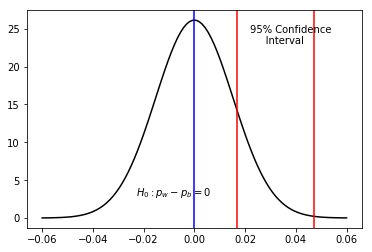

In [13]:
# Graph the Frequentist results
x = np.linspace(- 0.06, 0.06, 100, endpoint=True)
pdf =[stats.norm.pdf(_, loc=0, scale=Margin_of_err) for _ in x]
plt.plot(x, pdf, 'k-')

_ = plt.axvline(CI_high, color='red')
_ = plt.axvline(CI_low, color='red')
_ = plt.axvline(0, color='blue')
_ = plt.text(-0.023, 3, '$H_0: p_w - p_b = 0$')
_ = plt.text(0.022, 23, '95% Confidence \n     Interval')


In [17]:
# Construct arrays of data: white-sounding names, black-sounding names
all_callbacks = np.array(data.call)
prop_diff=p1-p2
bs_reps_diff = np.empty(10000)
for i in range(10000):
    w_bs_replicates = np.sum(np.random.choice(all_callbacks, size=int(n1)))
    b_bs_replicates = np.sum(np.random.choice(all_callbacks, size=int(n2)))
    bs_reps_diff[i] = (w_bs_replicates - b_bs_replicates)/int(n2)

bs_p_value = np.sum(bs_reps_diff >= prop_diff) / len(bs_reps_diff)
bs_ci = np.percentile(bs_reps_diff, [2.5, 97.5]) #95% confidance interval is between 2.5 and 97.5 quartiles. 

print('obs diff: {}'.format(prop_diff))
print('np-value: {}\n95% conf. int.: {}'.format(bs_p_value, bs_ci))

obs diff: 0.032032854209445585
np-value: 0.0
95% conf. int.: [-0.01519507  0.01519507]


<div class="span5 alert alert-info">

<b>Answer Q3 </b>

Null Hypothesis: the probability of success (getting a callback) is the same for both resumes with white-sounding names and black-sounding names. $$H: Pw-Pb=0$$

Both frequentist and bootstrapping approch had a p_value smaller than 0.05. That means that null hypothesis must be rejected in favor of the alternate hypothesis. 
$$Frequentist Approch$$<br>
$$P-value:3.983886837577444e-05$$<br>
$$ Confidance interval : ( 0.016777447859559147 - 0.047288260559332024)$$<br>

<br>

$$Bootsrapping$$<br>
$$P-value: 0.0$$<br>
$$ confidance-interval:(-0.01519507 - 0.01519507) $$<br>
    
</div> 



<div class="span5 alert alert-warning">
<h2>Q4 -Write a story describing the statistical significance in the context or the original problem.</h2>
</div> 



<div class="span5 alert alert-info">

<b>Answer Q4 </b>
<p>Write a story describing the statistical significance in the context or the original problem.<br>

As it is seen from the data and statistics call back for  proportion of the white-sounding names is significantly and consistently higher than the proportion of callbacks for black-sounding names. The difference between proportions are clear and significant. This study proves the Racial Discrimination in the US Job Market.






</p>
</div>

<div class="span5 alert alert-warning">
<h2>Q5 -Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?</h2>
</div> 



<div class="span5 alert alert-info">

<b>Answer Q5 </b>
<p>Write a story describing the statistical significance in the context or the original problem.<br>

This study clearly shows the Racial Discrimination in the US Job Market for calling back the candidate based on how their names are sounded like. 

Yes,Hypothesis suggests that This analysis mean that race/name is the significant important factor in callback success.

However, I would like to include education background, work experince, criminal back ground etc. to this study to see if any other factors plays significant role on call back based on racial sounded names.





</p>
</div>